In [41]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
vocab_size = 20
embedding_dim = 512
dropout_prob = 0.5
num_heads = 8
seq_len = 5
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
input_ids = torch.randint(low=0, high=vocab_size, size=(1, seq_len))
embeddings = embedding_layer(input_ids)

In [43]:
def check_shape(func, shape, *args, **kwargs):
	assert func(*args, **kwargs).shape == shape
expected_shape = torch.Size([1, seq_len, embedding_dim])

# Scaled dot prod attention / Optional Mask

In [44]:
def scaled_dot_product_attention(query, key, value, mask=None, verbose=False):
	## query, key, value - bs, num_tokens, embedding_size
	attention_scores = torch.bmm(query, key.transpose(1, 2)) # bs, num_tokens, num_tokens
	attention_scores /= math.sqrt(query.shape[-1])

	# Apply mask before softmax
	if mask is not None:
		if verbose:
			print ("\n-------Before-------\n")
			print (attention_scores)
		attention_scores.masked_fill_(mask == 0, -float('inf')) # '_' means its an in-place op

		if verbose:
			print ("\n-------After-------\n")
			print (attention_scores)

	attention_weights = F.softmax(attention_scores, dim=-1)

	if verbose:
		print ("\n-------Attention Weights-------\n")
		print (attention_weights)
	assert (torch.allclose(attention_weights[0].sum(-1), torch.ones(attention_weights.shape[1])))
	return torch.bmm(attention_weights, value)

In [46]:
check_shape(scaled_dot_product_attention, expected_shape, embeddings, embeddings, embeddings)

# Attention Layer

In [47]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, embedding_dim, mask=None):
        super().__init__()
        self.query = nn.Linear(input_dim, embedding_dim)
        self.key = nn.Linear(input_dim, embedding_dim)
        self.value = nn.Linear(input_dim, embedding_dim)
        self.mask = mask
    
    def forward(self, x):
        query_embed = self.query(x)
        key_embed = self.key(x)
        value_embed = self.value(x)
        
        return scaled_dot_product_attention(query_embed, key_embed, value_embed, self.mask)

In [48]:
check_shape(AttentionLayer(embedding_dim, embedding_dim).forward, expected_shape, embeddings)

# Multi-Head Attention

In [49]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embedding_dim, attention_layer, mask=None):
        super().__init__()
        self.num_heads = num_heads
        per_head_dim = embedding_dim // num_heads
        self.attention_layers = nn.ModuleList([attention_layer(embedding_dim, per_head_dim, mask) 
                                               for _ in range(num_heads)])
        self.lin = nn.Linear(embedding_dim, embedding_dim)
        
    def forward(self, x, key=None, value=None):
        if key is not None and value is not None:
            x = torch.cat([self.attention_layers[i](x, key, value) for i in range(self.num_heads)], dim=-1)
        else:
            x = torch.cat([self.attention_layers[i](x) for i in range(self.num_heads)], dim=-1)
        return self.lin(x)

In [50]:
check_shape(MultiHeadAttention(num_heads, embedding_dim, AttentionLayer).forward, expected_shape, embeddings)

# Position-wise FFN aka 1-D Conv

In [51]:
class PFFN(nn.Module): 
	def __init__(self, embedding_dim, dropout_prob):
		super().__init__()
		self.lin1 = nn.Linear(embedding_dim, embedding_dim * 4)
		self.lin2 = nn.Linear(embedding_dim * 4, embedding_dim)
		self.dropout = nn.Dropout(dropout_prob)

	def forward(self, x):
		x = F.gelu(self.lin1(x))
		x = self.dropout(self.lin2(x))
		return x

In [52]:
check_shape(PFFN(embedding_dim, dropout_prob).forward, expected_shape, embeddings)

# LayerNorm, Skip-connections and the Encoder Layer

In [53]:
class TransformerEncoderLayer(nn.Module):
	def __init__(self, num_heads, embedding_dim, dropout_prob):
		super().__init__()
		self.attention = MultiHeadAttention(num_heads, embedding_dim, AttentionLayer)
		self.layer_norm1 = nn.LayerNorm(embedding_dim)
		self.pffn = PFFN(embedding_dim, dropout_prob)
		self.layer_norm2 = nn.LayerNorm(embedding_dim)

	def forward(self, x):
		attn_op = self.attention(x)
		x = x + attn_op # Skip connection
		x = self.layer_norm1(x)
		x = self.pffn(x) + x # Skip connection
		return self.layer_norm2(x)

In [54]:
check_shape(TransformerEncoderLayer(num_heads, embedding_dim, dropout_prob).forward, expected_shape, embeddings)

# Masked Multi-Head Attention

In [55]:
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
check_shape(scaled_dot_product_attention, expected_shape, embeddings, embeddings, embeddings, mask=mask, verbose=False)

In [56]:
check_shape(MultiHeadAttention(num_heads, embedding_dim, AttentionLayer, mask).forward, expected_shape, embeddings)

# Encoder-Decoder Attention

In [57]:
class EncoderDecoderAttentionLayer(nn.Module):
    def __init__(self, input_dim, embedding_dim, mask=None):
        super().__init__()
        self.query = nn.Linear(input_dim, embedding_dim)
        self.key = nn.Linear(input_dim, embedding_dim)
        self.value = nn.Linear(input_dim, embedding_dim)
        self.mask = mask
    
    def forward(self, x, key, value):
        query_embed = self.query(x)
        key_embed = self.key(key)
        value_embed = self.key(value)

        return scaled_dot_product_attention(query_embed, key_embed, value_embed, self.mask)

In [58]:
check_shape(EncoderDecoderAttentionLayer(embedding_dim, embedding_dim).forward, expected_shape,
            embeddings, embeddings, embeddings)

In [59]:
check_shape(MultiHeadAttention(num_heads, embedding_dim, EncoderDecoderAttentionLayer, mask).forward, expected_shape, 
            x=embeddings, key=embeddings, value=embeddings)

# DecoderLayer

In [60]:
class TransformerDecoderLayer(nn.Module):
	def __init__(self, num_heads, embedding_dim, dropout_prob, mask):
		super().__init__()
		self.masked_attention = MultiHeadAttention(num_heads, embedding_dim, AttentionLayer, mask)
		self.encoder_decoder_attention = MultiHeadAttention(num_heads, embedding_dim, EncoderDecoderAttentionLayer)
		self.pffn = PFFN(embedding_dim, dropout_prob)
		self.layer_norm1 = nn.LayerNorm(embedding_dim)
		self.layer_norm2 = nn.LayerNorm(embedding_dim)
		self.layer_norm3 = nn.LayerNorm(embedding_dim)

	def forward(self, x, key, value):
		attn_op = self.masked_attention(x)
		x = x + attn_op # Skip connection
		layer_norm_op = self.layer_norm1(x)
		enc_dec_attn_op = self.encoder_decoder_attention(layer_norm_op, key, value)
		x = enc_dec_attn_op + layer_norm_op # Skip connection
		layer_norm_op = self.layer_norm2(x)
		x = self.pffn(x) + x # Skip connection
		return self.layer_norm3(x)

In [61]:
check_shape(TransformerDecoderLayer(num_heads, embedding_dim, dropout_prob, mask).forward, expected_shape,
            x=embeddings, key=embeddings, value=embeddings)

# Encoder, Decoder and Transformer Network

In [62]:
class Transformer(nn.Module):
    def __init__(self, num_heads, embedding_layer, pos_embedding_layer, dropout_prob, seq_len, num_classes):
        super().__init__()
        embedding_dim = embedding_layer.embedding_dim
        self.embedding_layer = embedding_layer
        self.pos_embedding_layer = pos_embedding_layer
        self.embedding_layer_norm = nn.LayerNorm(embedding_dim)
        self.enc = TransformerEncoderLayer(num_heads, embedding_dim, dropout_prob)
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
        self.dec = TransformerDecoderLayer(num_heads, embedding_dim, dropout_prob, mask)
        self.lin = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, token_ids, labels=None):
        embeddings = self.embedding_layer(token_ids)
        seq_len = token_ids.shape[-1]
        pos_embeddings = self.pos_embedding_layer(torch.arange(seq_len)).unsqueeze(0)
        embeddings = self.embedding_layer_norm(embeddings + pos_embeddings)
        x = self.enc(embeddings)
        
        if labels is not None:
            dec_embeddings = self.embedding_layer(labels) + pos_embeddings
            x = self.dec(dec_embeddings, x, x) # Pass op of encoder as key and value args
            return self.lin(x)


In [78]:
import random
input_ids = torch.Tensor(random.sample(range(vocab_size // 2), seq_len)).long()
labels = torch.Tensor(random.sample(range(vocab_size // 2, vocab_size), seq_len)).long()
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
positional_embedding_layer = nn.Embedding(seq_len, embedding_dim)
transformer = Transformer(num_heads, embedding_layer, positional_embedding_layer, dropout_prob, seq_len, vocab_size)

check_shape(transformer.forward, torch.Size([1, seq_len, vocab_size]), input_ids, labels)

# Overfit

In [79]:
input_ids, labels

(tensor([3, 9, 2, 6, 8]), tensor([12, 18, 19, 13, 17]))

In [80]:
import torch.optim as optim
from tqdm import tqdm
optimizer = optim.SGD(transformer.parameters(), lr=1e-4)
num_epochs = 100
losses = []

for i in tqdm(range(num_epochs)):
    op = transformer(input_ids, labels).squeeze()
    loss = F.cross_entropy(op, labels.squeeze())
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


100%|██████████| 100/100 [00:00<00:00, 100.84it/s]


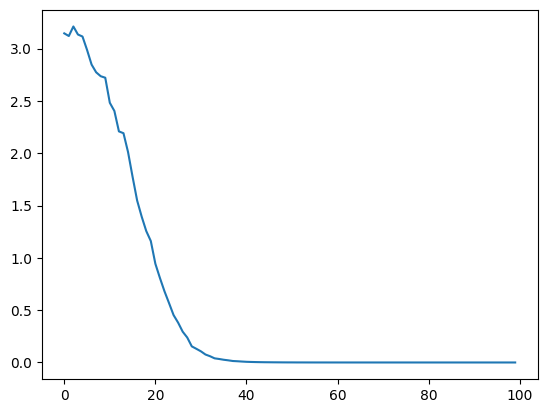

In [81]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losses))), losses)

In [82]:
op = transformer(input_ids, labels)
if (op.argmax(dim=2) == labels).all():
	print ("Overfits!")

Overfits!
